In [1]:
# %load /Users/facai/Study/book_notes/preconfig.py
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font='SimHei', font_scale=2.5)
plt.rcParams['axes.grid'] = False

#import numpy as np

#import pandas as pd
#pd.options.display.max_rows = 20

#import sklearn

#import itertools

#import logging
#logger = logging.getLogger()

#from IPython.display import SVG
def show_image(filename, figsize=None, res_dir=True):
    if figsize:
        plt.figure(figsize=figsize)

    if res_dir:
        filename = './res/{}'.format(filename)

    plt.imshow(plt.imread(filename))

10 Sequence Modeling: Recurrent and Recursive Nets
==============

RNN: to process sequential data

traditionaly fully connected feedforward network: separate parameters at each position.
=> recurrent neural network: shares the same parameters across several steps.

### 10.1 Unfoliding Computational Graphs

recurrent neural networks: $h^{(t)} = f(h^{(t-1)}, x^{(t)}; \theta)$

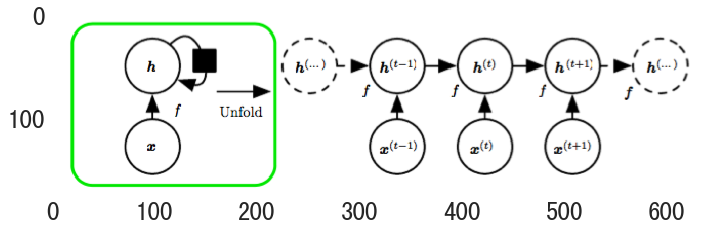

In [2]:
show_image('fig10_2.png', figsize=(12, 5))

two major advantages:
+ same input size even for a variable-length sequence.
+ use the **same** transition function $f$ with the same parameters at every time step.

unfolded graph: computing gradients

### 10.2 Recurrent Neural Networks

Different recurrent networks:

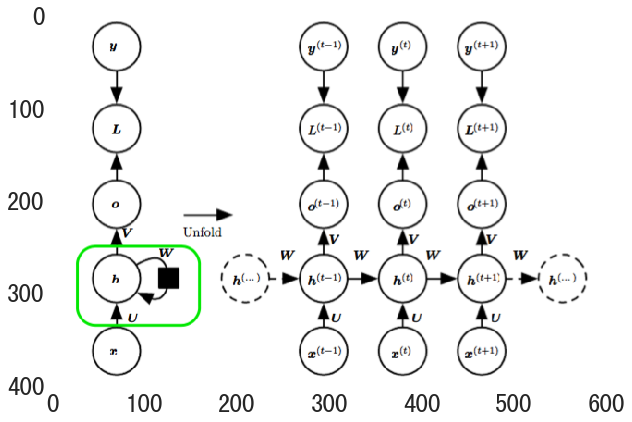

In [6]:
# A.
show_image('fig10_3.png', figsize=(10, 8))

\begin{align}
    a^t &= b + W h^{(t-1)} + U x^t \\
    h^t &= \tanh(a^t) \\
    o^t &= c + V h^t \\
    \hat{y}^t &= \operatorname{softmax}(o^t) \\
\end{align}

The total loss for a given sequence of $x$ values paired with a sequence of $y$ values would be just the sum of the losses over all the time steps:

\begin{align}
    &L \left ( \{x^1, \cdots, x^\tau\}, \{y^1, \cdots, y^\tau\}) \right ) \\
    &= \sum_t L^t \\
    &= - \sum_t \log p_{\text{model}} \left ( y^t \, | \, \{x^1, \cdots, x^\tau\} \right ) \\
\end{align}

So the back-propagation algorithm need $O(\tau)$ running time moving right to left through the graph, and also $O(\tau)$ memory cost to store the intermediate states. => back-propagation through time (BPTT): **powerful but also expensive to train**

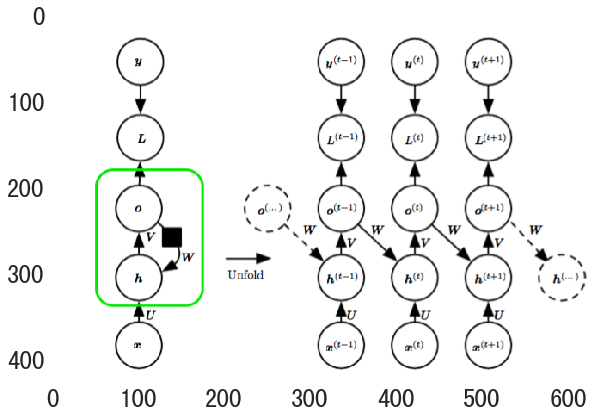

In [4]:
# B.
show_image('fig10_4.png', figsize=(10, 8))

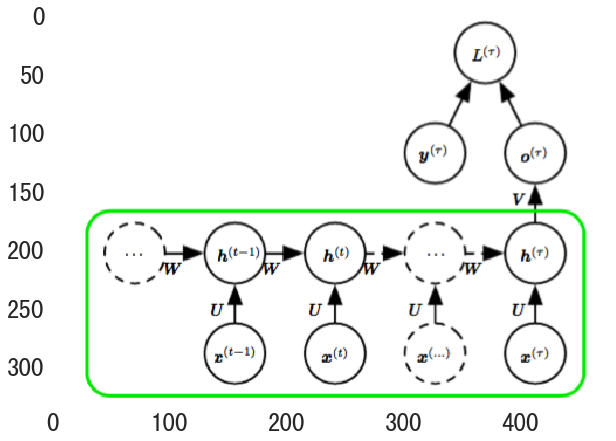

In [7]:
# C.
show_image('fig10_5.png', figsize=(10, 8))